In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as smi
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from statistics import mean
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, SimpleRNN, GRU, Dropout, Conv1D, MaxPooling1D, Flatten, RepeatVector
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error, mean_absolute_error
from tensorflow.keras.optimizers import Adam, Nadam, RMSprop
from statsmodels.tsa.seasonal import seasonal_decompose
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from hyperopt import hp, Trials, fmin, tpe
import joblib
import warnings
warnings.simplefilter('ignore')

In [3]:
df=pd.read_csv(r'E:\A aPython Programms\Data1\Bank.csv')
df.head(5)

,Date,AXISBANK,AXISVOL,BAJAJFIN,BAJAJFINVOL,BOB,BOBVOL,FEDBANK,FEDVOL,HDFC,...,KOTAK,KOTAKVOL,PNB,PNBVOL,SBI,SBIVOL,REC,RECVOL,PIRAMAL,PIRAMALVOL
0,02-01-2009,108.379997,14261265,6.310420,141738,57.340000,1700495,16.889999,1359910,101.565002,...,97.900002,6258884,106.430000,2973855,133.184998,24161650,29.587500,9574565,134.700485,222908
1,05-01-2009,112.019997,9165605,6.504736,1120575,58.860001,2687100,17.129999,4379460,104.410004,...,99.637497,5956956,107.160004,3037185,136.080002,26931910,30.562500,8844514,136.025497,14449
2,06-01-2009,113.949997,12893855,6.660189,312830,57.750000,3162520,16.760000,1930260,110.040001,...,96.712502,9015300,106.089996,4110100,132.285004,35970960,29.831249,1078005,133.516418,102783
3,07-01-2009,104.419998,10571555,6.150109,166223,54.939999,5602350,16.459999,2251090,100.925003,...,90.762497,6482408,97.660004,6538860,124.004997,37268580,28.424999,5624090,131.853104,24863
4,09-01-2009,97.320000,25173105,6.048093,95905,54.689999,1806325,16.004999,4046570,101.750000,...,86.125000,5076276,97.129997,3834090,122.110001,24996510,28.818750,6157634,129.654144,301873


In [4]:
feature_columns = [ 'SBI', 'SBIVOL', 'BAJAJFIN', 'FEDBANK', 'ICICI']
target_column = ['SBI']
features = df[feature_columns]
target = df[target_column].shift(-3)

new_data1 = 758.30
target.iloc[-3, 0] = new_data1

new_data2 = 766.40
target.iloc[-2, 0] = new_data2

new_data3 = 771.05
target.iloc[-1, 0] = new_data3

target.tail(5)

,SBI
3748,733.299988
3749,752.349976
3750,758.300000
3751,766.400000
3752,771.050000


In [5]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_features = scaler.fit_transform(features)
scaled_target = scaler.fit_transform(target.values.reshape(-1, 1))
target=target.dropna()

n_steps = 5  # Number of timesteps to look back
X, y = [], []

for i in range(n_steps, len(scaled_features)):
    X.append(scaled_features[i-n_steps:i])
    y.append(scaled_target[i])

X = np.array(X)
y = np.array(y)

split=int(0.8*len(X))
X_train, y_train= X[:split], y[:split]
X_test, y_test= X[split:], y[split:]

In [6]:
model_lstm = load_model('model_lstm_sbi3h_0.9644.keras')
model_lstm.predict(X_test)

predictions_lstm = model_lstm.predict(X_test)
predictions_LSTM = scaler.inverse_transform(predictions_lstm)
y_test_actual_LSTM = scaler.inverse_transform(y_test.reshape(-1, 1))

r2=r2_score(y_test_actual_LSTM, predictions_LSTM)
print(f"R2: {r2:.4f}")

mape=mean_absolute_percentage_error(y_test_actual_LSTM, predictions_LSTM)
print(f"MAPE: {mape:.4f}")

mse=mean_squared_error(y_test_actual_LSTM, predictions_LSTM)
rmse=np.sqrt(mse)
print(f"RMSE: {rmse:.4f}")

mse_normalizeddata=mean_squared_error(y_test, predictions_lstm)
rmse_normalizeddata=np.sqrt(mse_normalizeddata)
print(f"RMSE_normalizeddata: {rmse_normalizeddata:.4f}")

mae_n=mean_absolute_error(y_test, predictions_lstm)
print(f"MAE_normalizeddata: {mae_n:.4f}")

mae=mean_absolute_error(y_test_actual_LSTM, predictions_LSTM)
print(f"MAE: {mae:.4f}")

24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
R2: 0.9644
MAPE: 0.0240
RMSE: 16.4475
RMSE_normalizeddata: 0.0235
MAE_normalizeddata: 0.0180
MAE: 12.5926


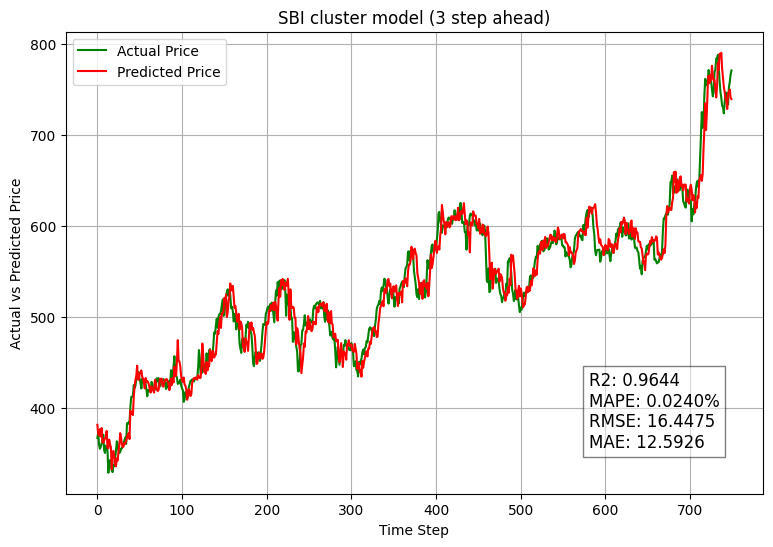

In [7]:
plt.figure(figsize=(9, 6))
plt.plot(y_test_actual_LSTM, color='green', label=['Actual Price'])
plt.plot(predictions_LSTM, color='red', label=['Predicted Price'])
plt.legend(['Actual Price', 'Predicted Price'], loc='upper left')

plt.text(0.75, 0.1, f'R2: {r2:.4f}\nMAPE: {mape:.4f}%\nRMSE: {rmse:.4f}\nMAE: {mae:.4f}', 
         fontsize=12, 
         bbox=dict(facecolor='white', alpha=0.5),
         transform=plt.gca().transAxes)

plt.grid(True)
plt.title('SBI cluster model (3 step ahead)')
plt.xlabel('Time Step')
plt.ylabel('Actual vs Predicted Price')
plt.savefig('sbicluster_3sa-1l.jpg', dpi=600)  # Saves the plot as a PNG file
plt.show()

In [156]:
model_lstm.predict(X_train)

predictions_train_lstm = model_lstm.predict(X_train)
predictions_train_LSTM = scaler.inverse_transform(predictions_train_lstm)
y_train_actual_LSTM = scaler.inverse_transform(y_train.reshape(-1, 1))

r2=r2_score(y_train_actual_LSTM, predictions_train_LSTM)
print(f"R2: {r2:.4f}")

mape=mean_absolute_percentage_error(y_train_actual_LSTM, predictions_train_LSTM)
print(f"MAPE: {mape:.4f}")

mse=mean_squared_error(y_train_actual_LSTM, predictions_train_LSTM)
rmse=np.sqrt(mse)
print(f"RMSE: {rmse:.4f}")

mse_normalizeddata=mean_squared_error(y_train, predictions_train_lstm)
rmse_normalizeddata=np.sqrt(mse_normalizeddata)
print(f"RMSE_normalizeddata: {rmse_normalizeddata:.4f}")

mae_n=mean_absolute_error(y_train, predictions_train_lstm)
print(f"MAE_normalizeddata: {mae_n:.4f}")

mae=mean_absolute_error(y_train_actual_LSTM, predictions_train_LSTM)
print(f"MAE: {mae:.4f}")

94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
R2: 0.9558
MAPE: 0.0365
RMSE: 11.4090
RMSE_normalizeddata: 0.0163
MAE_normalizeddata: 0.0122
MAE: 8.5392


In [134]:
model_lstm = tf.keras.Sequential()
model_lstm.add(tf.keras.layers.LSTM(169, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False))
model_lstm.add(tf.keras.layers.Dense(1))
model_lstm.compile(optimizer=Nadam(learning_rate=0.00398), loss='mse')
model_lstm.fit(X_train, y_train, epochs=200, batch_size=30, validation_data=(X_test, y_test), callbacks=[EarlyStopping(monitor='loss', patience=5)])

predictions_lstm = model_lstm.predict(X_test)
predictions_LSTM = scaler.inverse_transform(predictions_lstm)
y_test_actual_LSTM = scaler.inverse_transform(y_test.reshape(-1, 1))

r2=r2_score(y_test_actual_LSTM, predictions_LSTM)
print(f"R2: {r2:.4f}")

mape=mean_absolute_percentage_error(y_test_actual_LSTM, predictions_LSTM)
print(f"MAPE: {mape:.4f}")

mse=mean_squared_error(y_test_actual_LSTM, predictions_LSTM)
rmse=np.sqrt(mse)
print(f"RMSE: {rmse:.4f}")

mse_normalizeddata=mean_squared_error(y_test, predictions_lstm)
rmse_normalizeddata=np.sqrt(mse_normalizeddata)
print(f"RMSE_normalizeddata: {rmse_normalizeddata:.4f}")

mae=mean_absolute_error(y_test_actual_LSTM, predictions_LSTM)
print(f"MAE: {mae:.4f}")

Epoch 1/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - loss: 0.0043 - val_loss: 0.0010
Epoch 2/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 3.5421e-04 - val_loss: 0.0031
Epoch 3/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 3.7450e-04 - val_loss: 7.4017e-04
Epoch 4/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 3.6009e-04 - val_loss: 0.0020
Epoch 5/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 3.5485e-04 - val_loss: 9.1613e-04
Epoch 6/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 3.7804e-04 - val_loss: 0.0012
Epoch 7/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 3.1340e-04 - val_loss: 9.1842e-04
Epoch 8/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 3.5170e-04 - val_loss: 9.0387e-04
Epoch 9/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 2.8920e-04 - val_loss: 0.0020
Epoch 10/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 3.0271e-04 - val_loss: 7.9041e-04
Epoch 11/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 3.3708e-0

In [135]:
model_lstm.save('model_lstm_sbi3h_1.keras')

In [136]:
model_lstm = tf.keras.Sequential()
model_lstm.add(tf.keras.layers.LSTM(169, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False))
model_lstm.add(tf.keras.layers.Dense(1))
model_lstm.compile(optimizer=Nadam(learning_rate=0.00398), loss='mse')
model_lstm.fit(X_train, y_train, epochs=200, batch_size=30, validation_data=(X_test, y_test), callbacks=[EarlyStopping(monitor='loss', patience=5)])

predictions_lstm = model_lstm.predict(X_test)
predictions_LSTM = scaler.inverse_transform(predictions_lstm)
y_test_actual_LSTM = scaler.inverse_transform(y_test.reshape(-1, 1))

r2=r2_score(y_test_actual_LSTM, predictions_LSTM)
print(f"R2: {r2:.4f}")

mape=mean_absolute_percentage_error(y_test_actual_LSTM, predictions_LSTM)
print(f"MAPE: {mape:.4f}")

mse=mean_squared_error(y_test_actual_LSTM, predictions_LSTM)
rmse=np.sqrt(mse)
print(f"RMSE: {rmse:.4f}")

mse_normalizeddata=mean_squared_error(y_test, predictions_lstm)
rmse_normalizeddata=np.sqrt(mse_normalizeddata)
print(f"RMSE_normalizeddata: {rmse_normalizeddata:.4f}")

mae=mean_absolute_error(y_test_actual_LSTM, predictions_LSTM)
print(f"MAE: {mae:.4f}")

Epoch 1/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0057 - val_loss: 0.0017
Epoch 2/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 3.8297e-04 - val_loss: 0.0011
Epoch 3/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 3.8408e-04 - val_loss: 0.0021
Epoch 4/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 3.9095e-04 - val_loss: 0.0011
Epoch 5/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 3.9296e-04 - val_loss: 9.7378e-04
Epoch 6/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 3.4343e-04 - val_loss: 0.0012
Epoch 7/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 3.5701e-04 - val_loss: 8.1210e-04
Epoch 8/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 3.1040e-04 - val_loss: 0.0026
Epoch 9/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 3.3615e-04 - val_loss: 0.0012
Epoch 10/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 3.3922e-04 - val_loss: 6.8814e-04
Epoch 11/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 3.2131e-04 - val_l

In [137]:
model_lstm.save('model_lstm_sbi3h_2.keras')

In [138]:
model_lstm = tf.keras.Sequential()
model_lstm.add(tf.keras.layers.LSTM(169, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False))
model_lstm.add(tf.keras.layers.Dense(1))
model_lstm.compile(optimizer=Nadam(learning_rate=0.00398), loss='mse')
model_lstm.fit(X_train, y_train, epochs=200, batch_size=30, validation_data=(X_test, y_test), callbacks=[EarlyStopping(monitor='loss', patience=5)])

predictions_lstm = model_lstm.predict(X_test)
predictions_LSTM = scaler.inverse_transform(predictions_lstm)
y_test_actual_LSTM = scaler.inverse_transform(y_test.reshape(-1, 1))

r2=r2_score(y_test_actual_LSTM, predictions_LSTM)
print(f"R2: {r2:.4f}")

mape=mean_absolute_percentage_error(y_test_actual_LSTM, predictions_LSTM)
print(f"MAPE: {mape:.4f}")

mse=mean_squared_error(y_test_actual_LSTM, predictions_LSTM)
rmse=np.sqrt(mse)
print(f"RMSE: {rmse:.4f}")

mse_normalizeddata=mean_squared_error(y_test, predictions_lstm)
rmse_normalizeddata=np.sqrt(mse_normalizeddata)
print(f"RMSE_normalizeddata: {rmse_normalizeddata:.4f}")

mae=mean_absolute_error(y_test_actual_LSTM, predictions_LSTM)
print(f"MAE: {mae:.4f}")

Epoch 1/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 0.0040 - val_loss: 0.0021
Epoch 2/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 3.5285e-04 - val_loss: 9.8287e-04
Epoch 3/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 3.9531e-04 - val_loss: 7.7443e-04
Epoch 4/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 3.5790e-04 - val_loss: 0.0025
Epoch 5/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 3.6658e-04 - val_loss: 9.6136e-04
Epoch 6/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 3.0311e-04 - val_loss: 7.6215e-04
Epoch 7/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 3.1767e-04 - val_loss: 9.9331e-04
Epoch 8/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 3.0703e-04 - val_loss: 0.0012
Epoch 9/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 3.2281e-04 - val_loss: 6.4959e-04
Epoch 10/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 3.2512e-04 - val_loss: 0.0011
Epoch 11/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss

In [139]:
model_lstm.save('model_lstm_sbi3h_3.keras')

In [140]:
model_lstm = tf.keras.Sequential()
model_lstm.add(tf.keras.layers.LSTM(169, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False))
model_lstm.add(tf.keras.layers.Dense(1))
model_lstm.compile(optimizer=Nadam(learning_rate=0.00398), loss='mse')
model_lstm.fit(X_train, y_train, epochs=200, batch_size=30, validation_data=(X_test, y_test), callbacks=[EarlyStopping(monitor='loss', patience=5)])

predictions_lstm = model_lstm.predict(X_test)
predictions_LSTM = scaler.inverse_transform(predictions_lstm)
y_test_actual_LSTM = scaler.inverse_transform(y_test.reshape(-1, 1))

r2=r2_score(y_test_actual_LSTM, predictions_LSTM)
print(f"R2: {r2:.4f}")

mape=mean_absolute_percentage_error(y_test_actual_LSTM, predictions_LSTM)
print(f"MAPE: {mape:.4f}")

mse=mean_squared_error(y_test_actual_LSTM, predictions_LSTM)
rmse=np.sqrt(mse)
print(f"RMSE: {rmse:.4f}")

mse_normalizeddata=mean_squared_error(y_test, predictions_lstm)
rmse_normalizeddata=np.sqrt(mse_normalizeddata)
print(f"RMSE_normalizeddata: {rmse_normalizeddata:.4f}")

mae=mean_absolute_error(y_test_actual_LSTM, predictions_LSTM)
print(f"MAE: {mae:.4f}")

Epoch 1/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - loss: 0.0060 - val_loss: 0.0011
Epoch 2/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 3.7343e-04 - val_loss: 0.0015
Epoch 3/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 3.6749e-04 - val_loss: 0.0020
Epoch 4/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 3.9679e-04 - val_loss: 0.0017
Epoch 5/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 3.4060e-04 - val_loss: 0.0022
Epoch 6/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 3.4833e-04 - val_loss: 7.3614e-04
Epoch 7/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 3.4304e-04 - val_loss: 0.0021
Epoch 8/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 3.3970e-04 - val_loss: 0.0015
Epoch 9/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 2.9978e-04 - val_loss: 0.0015
Epoch 10/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 3.0668e-04 - val_loss: 7.7206e-04
Epoch 11/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 2.7852e-04 - val_l

In [141]:
model_lstm.save('model_lstm_sbi3h_4.keras')

In [142]:
model_lstm = tf.keras.Sequential()
model_lstm.add(tf.keras.layers.LSTM(169, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False))
model_lstm.add(tf.keras.layers.Dense(1))
model_lstm.compile(optimizer=Nadam(learning_rate=0.00398), loss='mse')
model_lstm.fit(X_train, y_train, epochs=200, batch_size=30, validation_data=(X_test, y_test), callbacks=[EarlyStopping(monitor='loss', patience=5)])

predictions_lstm = model_lstm.predict(X_test)
predictions_LSTM = scaler.inverse_transform(predictions_lstm)
y_test_actual_LSTM = scaler.inverse_transform(y_test.reshape(-1, 1))

r2=r2_score(y_test_actual_LSTM, predictions_LSTM)
print(f"R2: {r2:.4f}")

mape=mean_absolute_percentage_error(y_test_actual_LSTM, predictions_LSTM)
print(f"MAPE: {mape:.4f}")

mse=mean_squared_error(y_test_actual_LSTM, predictions_LSTM)
rmse=np.sqrt(mse)
print(f"RMSE: {rmse:.4f}")

mse_normalizeddata=mean_squared_error(y_test, predictions_lstm)
rmse_normalizeddata=np.sqrt(mse_normalizeddata)
print(f"RMSE_normalizeddata: {rmse_normalizeddata:.4f}")

mae=mean_absolute_error(y_test_actual_LSTM, predictions_LSTM)
print(f"MAE: {mae:.4f}")

Epoch 1/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - loss: 0.0056 - val_loss: 9.2737e-04
Epoch 2/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 4.0068e-04 - val_loss: 9.9771e-04
Epoch 3/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 3.7076e-04 - val_loss: 0.0011
Epoch 4/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 3.4901e-04 - val_loss: 0.0029
Epoch 5/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 3.7478e-04 - val_loss: 0.0011
Epoch 6/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 3.7175e-04 - val_loss: 8.3971e-04
Epoch 7/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 3.3381e-04 - val_loss: 0.0016
Epoch 8/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 3.0168e-04 - val_loss: 7.9370e-04
Epoch 9/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 3.0482e-04 - val_loss: 9.1290e-04
Epoch 10/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 3.0663e-04 - val_loss: 0.0010
Epoch 11/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 2.946

In [143]:
model_lstm.save('model_lstm_sbi3h_5.keras')

In [144]:
model_lstm = tf.keras.Sequential()
model_lstm.add(tf.keras.layers.LSTM(169, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False))
model_lstm.add(tf.keras.layers.Dense(1))
model_lstm.compile(optimizer=Nadam(learning_rate=0.00398), loss='mse')
model_lstm.fit(X_train, y_train, epochs=200, batch_size=30, validation_data=(X_test, y_test), callbacks=[EarlyStopping(monitor='loss', patience=5)])

predictions_lstm = model_lstm.predict(X_test)
predictions_LSTM = scaler.inverse_transform(predictions_lstm)
y_test_actual_LSTM = scaler.inverse_transform(y_test.reshape(-1, 1))

r2=r2_score(y_test_actual_LSTM, predictions_LSTM)
print(f"R2: {r2:.4f}")

mape=mean_absolute_percentage_error(y_test_actual_LSTM, predictions_LSTM)
print(f"MAPE: {mape:.4f}")

mse=mean_squared_error(y_test_actual_LSTM, predictions_LSTM)
rmse=np.sqrt(mse)
print(f"RMSE: {rmse:.4f}")

mse_normalizeddata=mean_squared_error(y_test, predictions_lstm)
rmse_normalizeddata=np.sqrt(mse_normalizeddata)
print(f"RMSE_normalizeddata: {rmse_normalizeddata:.4f}")

mae=mean_absolute_error(y_test_actual_LSTM, predictions_LSTM)
print(f"MAE: {mae:.4f}")

Epoch 1/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step - loss: 0.0050 - val_loss: 0.0012
Epoch 2/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 3.6511e-04 - val_loss: 0.0017
Epoch 3/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 3.9356e-04 - val_loss: 0.0014
Epoch 4/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 4.4082e-04 - val_loss: 0.0011
Epoch 5/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 3.7261e-04 - val_loss: 7.7730e-04
Epoch 6/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 3.5522e-04 - val_loss: 7.2812e-04
Epoch 7/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 3.0161e-04 - val_loss: 8.0450e-04
Epoch 8/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 3.4884e-04 - val_loss: 0.0010
Epoch 9/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 3.1558e-04 - val_loss: 8.1583e-04
Epoch 10/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 3.2259e-04 - val_loss: 6.4265e-04
Epoch 11/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 

In [145]:
model_lstm.save('model_lstm_sbi3h_6.keras')

In [146]:
model_lstm = tf.keras.Sequential()
model_lstm.add(tf.keras.layers.LSTM(169, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False))
model_lstm.add(tf.keras.layers.Dense(1))
model_lstm.compile(optimizer=Nadam(learning_rate=0.00398), loss='mse')
model_lstm.fit(X_train, y_train, epochs=200, batch_size=30, validation_data=(X_test, y_test), callbacks=[EarlyStopping(monitor='loss', patience=5)])

predictions_lstm = model_lstm.predict(X_test)
predictions_LSTM = scaler.inverse_transform(predictions_lstm)
y_test_actual_LSTM = scaler.inverse_transform(y_test.reshape(-1, 1))

r2=r2_score(y_test_actual_LSTM, predictions_LSTM)
print(f"R2: {r2:.4f}")

mape=mean_absolute_percentage_error(y_test_actual_LSTM, predictions_LSTM)
print(f"MAPE: {mape:.4f}")

mse=mean_squared_error(y_test_actual_LSTM, predictions_LSTM)
rmse=np.sqrt(mse)
print(f"RMSE: {rmse:.4f}")

mse_normalizeddata=mean_squared_error(y_test, predictions_lstm)
rmse_normalizeddata=np.sqrt(mse_normalizeddata)
print(f"RMSE_normalizeddata: {rmse_normalizeddata:.4f}")

mae=mean_absolute_error(y_test_actual_LSTM, predictions_LSTM)
print(f"MAE: {mae:.4f}")

Epoch 1/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - loss: 0.0063 - val_loss: 0.0063
Epoch 2/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 3.9011e-04 - val_loss: 0.0018
Epoch 3/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 3.5908e-04 - val_loss: 0.0030
Epoch 4/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 3.5444e-04 - val_loss: 8.4514e-04
Epoch 5/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 3.4698e-04 - val_loss: 9.2703e-04
Epoch 6/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 3.4770e-04 - val_loss: 0.0019
Epoch 7/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 3.2750e-04 - val_loss: 0.0020
Epoch 8/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 3.2168e-04 - val_loss: 0.0027
Epoch 9/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 3.1675e-04 - val_loss: 0.0023
Epoch 10/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 3.1200e-04 - val_loss: 8.0502e-04
Epoch 11/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 3.1830e-04

In [147]:
model_lstm.save('model_lstm_sbi3h_7.keras')

In [148]:
model_lstm = tf.keras.Sequential()
model_lstm.add(tf.keras.layers.LSTM(169, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False))
model_lstm.add(tf.keras.layers.Dense(1))
model_lstm.compile(optimizer=Nadam(learning_rate=0.00398), loss='mse')
model_lstm.fit(X_train, y_train, epochs=200, batch_size=30, validation_data=(X_test, y_test), callbacks=[EarlyStopping(monitor='loss', patience=5)])

predictions_lstm = model_lstm.predict(X_test)
predictions_LSTM = scaler.inverse_transform(predictions_lstm)
y_test_actual_LSTM = scaler.inverse_transform(y_test.reshape(-1, 1))

r2=r2_score(y_test_actual_LSTM, predictions_LSTM)
print(f"R2: {r2:.4f}")

mape=mean_absolute_percentage_error(y_test_actual_LSTM, predictions_LSTM)
print(f"MAPE: {mape:.4f}")

mse=mean_squared_error(y_test_actual_LSTM, predictions_LSTM)
rmse=np.sqrt(mse)
print(f"RMSE: {rmse:.4f}")

mse_normalizeddata=mean_squared_error(y_test, predictions_lstm)
rmse_normalizeddata=np.sqrt(mse_normalizeddata)
print(f"RMSE_normalizeddata: {rmse_normalizeddata:.4f}")

mae=mean_absolute_error(y_test_actual_LSTM, predictions_LSTM)
print(f"MAE: {mae:.4f}")

Epoch 1/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.0055 - val_loss: 0.0064
Epoch 2/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 3.7529e-04 - val_loss: 0.0014
Epoch 3/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 3.3671e-04 - val_loss: 9.7871e-04
Epoch 4/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 3.6973e-04 - val_loss: 8.6622e-04
Epoch 5/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 3.2565e-04 - val_loss: 7.6688e-04
Epoch 6/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 3.3322e-04 - val_loss: 7.7003e-04
Epoch 7/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 2.9508e-04 - val_loss: 7.5443e-04
Epoch 8/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 3.1432e-04 - val_loss: 0.0017
Epoch 9/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 3.1665e-04 - val_loss: 9.7927e-04
Epoch 10/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 3.1195e-04 - val_loss: 6.6942e-04
Epoch 11/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - lo

In [149]:
model_lstm.save('model_lstm_sbi3h_8.keras')

In [150]:
model_lstm = tf.keras.Sequential()
model_lstm.add(tf.keras.layers.LSTM(169, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False))
model_lstm.add(tf.keras.layers.Dense(1))
model_lstm.compile(optimizer=Nadam(learning_rate=0.00398), loss='mse')
model_lstm.fit(X_train, y_train, epochs=200, batch_size=30, validation_data=(X_test, y_test), callbacks=[EarlyStopping(monitor='loss', patience=5)])

predictions_lstm = model_lstm.predict(X_test)
predictions_LSTM = scaler.inverse_transform(predictions_lstm)
y_test_actual_LSTM = scaler.inverse_transform(y_test.reshape(-1, 1))

r2=r2_score(y_test_actual_LSTM, predictions_LSTM)
print(f"R2: {r2:.4f}")

mape=mean_absolute_percentage_error(y_test_actual_LSTM, predictions_LSTM)
print(f"MAPE: {mape:.4f}")

mse=mean_squared_error(y_test_actual_LSTM, predictions_LSTM)
rmse=np.sqrt(mse)
print(f"RMSE: {rmse:.4f}")

mse_normalizeddata=mean_squared_error(y_test, predictions_lstm)
rmse_normalizeddata=np.sqrt(mse_normalizeddata)
print(f"RMSE_normalizeddata: {rmse_normalizeddata:.4f}")

mae=mean_absolute_error(y_test_actual_LSTM, predictions_LSTM)
print(f"MAE: {mae:.4f}")

Epoch 1/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - loss: 0.0030 - val_loss: 0.0014
Epoch 2/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 3.8125e-04 - val_loss: 8.6461e-04
Epoch 3/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 3.7752e-04 - val_loss: 8.1614e-04
Epoch 4/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 3.8470e-04 - val_loss: 0.0014
Epoch 5/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 3.5645e-04 - val_loss: 0.0012
Epoch 6/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 3.2899e-04 - val_loss: 0.0012
Epoch 7/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 3.3724e-04 - val_loss: 6.8614e-04
Epoch 8/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 3.1652e-04 - val_loss: 0.0011
Epoch 9/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 2.9418e-04 - val_loss: 6.4194e-04
Epoch 10/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 3.0302e-04 - val_loss: 0.0012
Epoch 11/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 3.5339e-04 - 

In [151]:
model_lstm.save('model_lstm_sbi3h_9.keras')

In [152]:
model_lstm = tf.keras.Sequential()
model_lstm.add(tf.keras.layers.LSTM(169, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False))
model_lstm.add(tf.keras.layers.Dense(1))
model_lstm.compile(optimizer=Nadam(learning_rate=0.00398), loss='mse')
model_lstm.fit(X_train, y_train, epochs=200, batch_size=30, validation_data=(X_test, y_test), callbacks=[EarlyStopping(monitor='loss', patience=5)])

predictions_lstm = model_lstm.predict(X_test)
predictions_LSTM = scaler.inverse_transform(predictions_lstm)
y_test_actual_LSTM = scaler.inverse_transform(y_test.reshape(-1, 1))

r2=r2_score(y_test_actual_LSTM, predictions_LSTM)
print(f"R2: {r2:.4f}")

mape=mean_absolute_percentage_error(y_test_actual_LSTM, predictions_LSTM)
print(f"MAPE: {mape:.4f}")

mse=mean_squared_error(y_test_actual_LSTM, predictions_LSTM)
rmse=np.sqrt(mse)
print(f"RMSE: {rmse:.4f}")

mse_normalizeddata=mean_squared_error(y_test, predictions_lstm)
rmse_normalizeddata=np.sqrt(mse_normalizeddata)
print(f"RMSE_normalizeddata: {rmse_normalizeddata:.4f}")

mae=mean_absolute_error(y_test_actual_LSTM, predictions_LSTM)
print(f"MAE: {mae:.4f}")

Epoch 1/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 0.0064 - val_loss: 0.0017
Epoch 2/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 4.0216e-04 - val_loss: 0.0023
Epoch 3/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 3.8386e-04 - val_loss: 0.0023
Epoch 4/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 3.7590e-04 - val_loss: 0.0020
Epoch 5/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 3.4318e-04 - val_loss: 0.0012
Epoch 6/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 3.8470e-04 - val_loss: 0.0025
Epoch 7/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 3.3369e-04 - val_loss: 0.0018
Epoch 8/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 3.3044e-04 - val_loss: 7.0171e-04
Epoch 9/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 3.3745e-04 - val_loss: 8.5546e-04
Epoch 10/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 2.9795e-04 - val_loss: 0.0016
Epoch 11/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 2.9954e-04 -

In [153]:
predictions_train_lstm = model_lstm.predict(X_train)
predictions_train_LSTM = scaler.inverse_transform(predictions_train_lstm)
y_train_actual_LSTM = scaler.inverse_transform(y_train.reshape(-1, 1))

r2=r2_score(y_train_actual_LSTM, predictions_train_LSTM)
print(f"R2: {r2:.4f}")

mape=mean_absolute_percentage_error(y_train_actual_LSTM, predictions_train_LSTM)
print(f"MAPE: {mape:.4f}")

mse=mean_squared_error(y_train_actual_LSTM, predictions_train_LSTM)
rmse=np.sqrt(mse)
print(f"RMSE: {rmse:.4f}")

mse_normalizeddata=mean_squared_error(y_train, predictions_train_lstm)
rmse_normalizeddata=np.sqrt(mse_normalizeddata)
print(f"RMSE_normalizeddata: {rmse_normalizeddata:.4f}")

mae_n=mean_absolute_error(y_train, predictions_train_lstm)
print(f"MAE_normalizeddata: {mae_n:.4f}")

mae=mean_absolute_error(y_train_actual_LSTM, predictions_train_LSTM)
print(f"MAE: {mae:.4f}")

94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
R2: 0.9582
MAPE: 0.0354
RMSE: 11.0880
RMSE_normalizeddata: 0.0159
MAE_normalizeddata: 0.0119
MAE: 8.3020


In [154]:
model_lstm.save('model_lstm_sbi3h_10.keras')